In [12]:
import time

import numpy as np
import pandas as pd

import anndata as ad
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

from markermap.vae_models import MarkerMap, train_model
from markermap.utils import (
    new_model_metrics,
    plot_confusion_matrix,
    split_data,
    plot_umap_embedding
)

from squidpy_markermap import dataset_squidpy, squidpy_markermap, eval_squidpy

from markermap import vae_models
print(vae_models.__file__)
from markermap import utils
print(utils.__file__)

%load_ext autoreload
%autoreload 2

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.23.4 scipy==1.13.0 pandas==2.2.1 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 louvain==0.8.2 pynndescent==0.5.12
squidpy==1.4.1
/home/ianubuntu4/COMPUTER/BMCS4480/final/MarkerMap/src/markermap/vae_models.py
/home/ianubuntu4/COMPUTER/BMCS4480/final/MarkerMap/src/markermap/utils.py
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [2]:
adata, train_dataloader, val_dataloader, train_indices, val_indices, test_indices, train_val_indices = dataset_squidpy()

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster', 'annotation'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
(2688, 18078)
(2688,)
['Cortex_1' 'Cortex_2' 'Cortex_3' 'Cortex_4' 'Cortex_5' 'Fiber_tract'
 'Hippocampu

/home/ianubuntu4/COMPUTER/BMCS4480/final/MarkerMap/src/markermap/utils.py:1086: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.utils.data.TensorDataset(torch.Tensor(X), torch.LongTensor(y)),


## Define and train the model

In [6]:
markers = []
params = {
    'z_size': 512,
    'hidden_layer_size': 2048,
    'k': 100,
}

for i in range(0, 6):
    print('model', i)
    tic = time.time()
    # mms.append(squidpy_markermap(params, adata, train_dataloader, val_dataloader))
    mm = squidpy_markermap(params, adata, train_dataloader, val_dataloader)
    toc = time.time()
    print('time_elapsed', toc-tic, 'seconds')
    markers.append(mm.markers().clone().cpu().detach().numpy())

model 0
Sequential(
  (0): Linear(in_features=18078, out_features=2048, bias=True)
  (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=2048, out_features=2048, bias=True)
  (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=2048, out_features=2048, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
)
in markermap
  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 45.4 M
1 | enc_mean               | Linear     | 1.0 M 
2 | enc_logvar             | Linear     | 1.0 M 
3 | decoder                | Sequential | 38.1 M
4 | dec_logvar             | Sequential | 38.1 M
5 | weight_creator         | Sequential | 78.3 M
6 | classification_decoder | Sequential | 1.1 M 
7 | classification_loss    | NLLLoss   

/home/ianubuntu4/.pyenv/versions/miniconda3-latest/envs/BMCS4480/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/ianubuntu4/.pyenv/versions/miniconda3-latest/envs/BMCS4480/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
Finding best initial lr: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.78it/s]


time_elapsed 137.05942940711975 seconds
model 1
Sequential(
  (0): Linear(in_features=18078, out_features=2048, bias=True)
  (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=2048, out_features=2048, bias=True)
  (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=2048, out_features=2048, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
)
in markermap
  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 45.4 M
1 | enc_mean               | Linear     | 1.0 M 
2 | enc_logvar             | Linear     | 1.0 M 
3 | decoder                | Sequential | 38.1 M
4 | dec_logvar             | Sequential | 38.1 M
5 | weight_creator         | Sequential | 78.3 M
6 | classification_decoder | Sequential | 1.1 M 

Finding best initial lr: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.97it/s]


time_elapsed 136.5793490409851 seconds
model 2
Sequential(
  (0): Linear(in_features=18078, out_features=2048, bias=True)
  (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=2048, out_features=2048, bias=True)
  (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=2048, out_features=2048, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
)
in markermap
  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 45.4 M
1 | enc_mean               | Linear     | 1.0 M 
2 | enc_logvar             | Linear     | 1.0 M 
3 | decoder                | Sequential | 38.1 M
4 | dec_logvar             | Sequential | 38.1 M
5 | weight_creator         | Sequential | 78.3 M
6 | classification_decoder | Sequential | 1.1 M 


Finding best initial lr: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.85it/s]


time_elapsed 135.96210360527039 seconds
model 3
Sequential(
  (0): Linear(in_features=18078, out_features=2048, bias=True)
  (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=2048, out_features=2048, bias=True)
  (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=2048, out_features=2048, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
)
in markermap
  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 45.4 M
1 | enc_mean               | Linear     | 1.0 M 
2 | enc_logvar             | Linear     | 1.0 M 
3 | decoder                | Sequential | 38.1 M
4 | dec_logvar             | Sequential | 38.1 M
5 | weight_creator         | Sequential | 78.3 M
6 | classification_decoder | Sequential | 1.1 M 

Finding best initial lr: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.00it/s]


time_elapsed 136.04929995536804 seconds
model 4
Sequential(
  (0): Linear(in_features=18078, out_features=2048, bias=True)
  (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=2048, out_features=2048, bias=True)
  (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=2048, out_features=2048, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
)
in markermap
  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 45.4 M
1 | enc_mean               | Linear     | 1.0 M 
2 | enc_logvar             | Linear     | 1.0 M 
3 | decoder                | Sequential | 38.1 M
4 | dec_logvar             | Sequential | 38.1 M
5 | weight_creator         | Sequential | 78.3 M
6 | classification_decoder | Sequential | 1.1 M 

Finding best initial lr: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.81it/s]


time_elapsed 136.29665660858154 seconds
model 5
Sequential(
  (0): Linear(in_features=18078, out_features=2048, bias=True)
  (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=2048, out_features=2048, bias=True)
  (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=2048, out_features=2048, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
)
in markermap
  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 45.4 M
1 | enc_mean               | Linear     | 1.0 M 
2 | enc_logvar             | Linear     | 1.0 M 
3 | decoder                | Sequential | 38.1 M
4 | dec_logvar             | Sequential | 38.1 M
5 | weight_creator         | Sequential | 78.3 M
6 | classification_decoder | Sequential | 1.1 M 

Finding best initial lr: 100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.72it/s]


time_elapsed 136.224956035614 seconds


Unique values: [   46   117   129   219   258   289   309   343   386   402   404   408
   442   448   455   500   509   561   574   593   674   700   727   771
   833   942   948  1025  1118  1306  1318  1410  1433  1437  1439  1465
  1481  1488  1513  1530  1539  1562  1607  1610  1661  1739  1816  1851
  1856  1945  1950  2077  2081  2123  2132  2153  2155  2224  2251  2255
  2285  2314  2331  2375  2403  2405  2407  2408  2434  2480  2500  2501
  2536  2540  2625  2628  2650  2675  2690  2724  2740  2775  2776  2822
  2844  2921  2953  2993  3038  3057  3063  3065  3099  3110  3153  3168
  3183  3203  3218  3236  3280  3283  3300  3309  3349  3354  3373  3392
  3411  3417  3433  3440  3509  3523  3528  3596  3713  3733  3749  3751
  3780  3781  3829  3835  3877  3909  3948  3970  4013  4141  4172  4227
  4234  4240  4275  4278  4344  4352  4377  4395  4528  4549  4651  4716
  4741  4764  4803  4826  4834  4859  4886  4893  4996  5048  5065  5184
  5280  5339  5379  5431  5449  5492

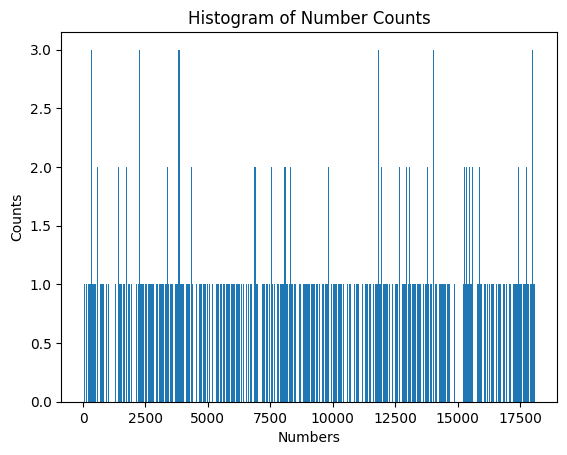

In [15]:
unique, counts = np.unique(markers, return_counts=True)
print("Unique values:", unique)
print("Counts:", counts)

# Creating the histogram
plt.bar(unique, counts, width=30)

# Adding titles and labels
plt.title('Histogram of Number Counts')
plt.xlabel('Numbers')
plt.ylabel('Counts')
# plt.xticks(unique)  # Ensure each unique value has a tick

# Show the plot
plt.show()